In [155]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress   
import warnings; warnings.simplefilter('ignore')

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use('fivethirtyeight')

In [702]:
data = pd.read_table('exp249_u.txt', sep='\t')
data['min'] = data['time'] * 10

data['above_thresh'] = data.groupby(by=['pos', 'label']).apply(lambda x: x['signal'] >= x['signal'].median() * 1.25).reset_index()['signal'].astype(int)

data_grouped = data.groupby(by=['pos', 'label'])
data['thresh_count'] = data_grouped['above_thresh'].cumsum()

data['id'] = 'P' + data['pos'].astype(str) + 'L' + data['label'].astype(str)

In [718]:
paper_cells = pd.read_table('cells.txt', sep='\t')

i1 = paper_cells.set_index('id').index
i2 = data.set_index('id').index

paper_data = data[i2.isin(i1)].set_index('id')
paper_data.drop(['pos', 'label', 'above_thresh', 'thresh_count'], axis=1, inplace=True)
paper_data['paper_label'] = paper_cells.set_index('id')['paper_label']

paper_data.to_csv('paper_data.txt', sep='\t')

In [661]:
avg_lifespan = (data_grouped['min'].last() - data_grouped['min'].first() + 10).mean()
print('The average lifespan per cell is approximately %f mins.' % avg_lifespan)

The average lifespan per cell is approximately 420.229777 mins.


In [662]:
avg_thresh_time = data[data['above_thresh']==1].groupby(by=['pos', 'label'])['thresh_count'].max().mean() * 10
print('The average time per cell spent above the threshold in its lifetime is approximately %f mins.' % avg_thresh_time)

The average time per cell spent above the threshold in its lifetime is approximately 105.663747 mins.


## How Interval between [Whi5] Peaks Change As Lifetime Progresses

In [663]:
thresh_interval = data[data['above_thresh']==1].set_index(['pos', 'label']).groupby(by=['pos', 'label'])['min'].diff().reset_index()
thresh_interval['time'] = data[data['above_thresh']==1]['time'].reset_index(drop=True)
thresh_interval.rename(columns={'min':'interval'}, inplace=True)
thresh_interval = thresh_interval[thresh_interval['interval'] != 10]
thresh_interval['interval'] = thresh_interval.groupby(by=['pos', 'label'])['time'].diff() * 10
thresh_interval.dropna(axis=0, inplace=True)

thresh_interval['interval'] = thresh_interval['interval'].astype(int)
thresh_interval['time'] = thresh_interval.groupby(by=['pos', 'label']).cumcount() + 1
thresh_interval


,pos,label,interval,time
2,1,1,120,1
3,1,1,180,2
4,1,1,80,3
5,1,1,80,4
6,1,1,90,5
7,1,1,140,6
8,1,1,70,7
9,1,1,60,8
10,1,1,360,9
11,1,1,60,10


Text(0.5,1,'Interval Between [Whi5] Peaks vs. Peak Number')

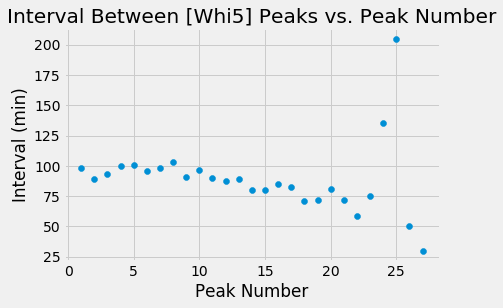

In [664]:
plt.scatter(thresh_interval.groupby(['time']).mean().index, thresh_interval.groupby(['time']).mean()['interval'])
plt.xlabel('Peak Number')
plt.ylabel('Interval (min)')
plt.title('Interval Between [Whi5] Peaks vs. Peak Number')

## Any Correlation between Area and Whi-5 Concentration

Text(0.5,0,'Whi5 Nuclear Concentration (AU)')

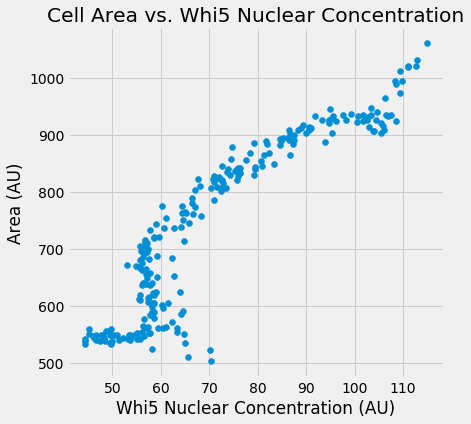

In [665]:
plt.figure(figsize=(6, 6))
plt.scatter(data.groupby(['min']).mean()['signal'], data.groupby(['min']).mean()['area'])
plt.title('Cell Area vs. Whi5 Nuclear Concentration')
plt.ylabel('Area (AU)')
plt.xlabel('Whi5 Nuclear Concentration (AU)')

## How Whi5 Nuclear Concentration Changes over Time

(0, 118.4013506932664)

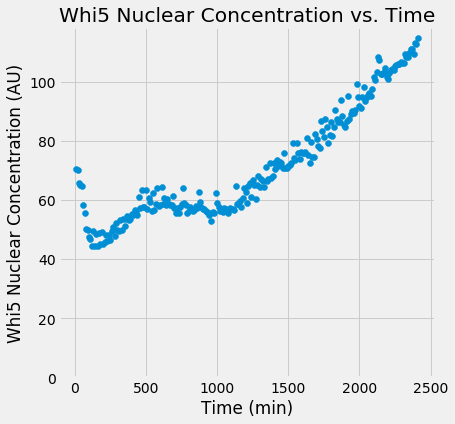

In [666]:
plt.figure(figsize=(6, 6))
plt.scatter(data.groupby(['min']).mean().index, data.groupby(['min']).mean()['signal'])
plt.title('Whi5 Nuclear Concentration vs. Time')
plt.xlabel('Time (min)')
plt.ylabel('Whi5 Nuclear Concentration (AU)')
plt.ylim(ymin=0)

## Cell Area and Whi5 Concentration over Time

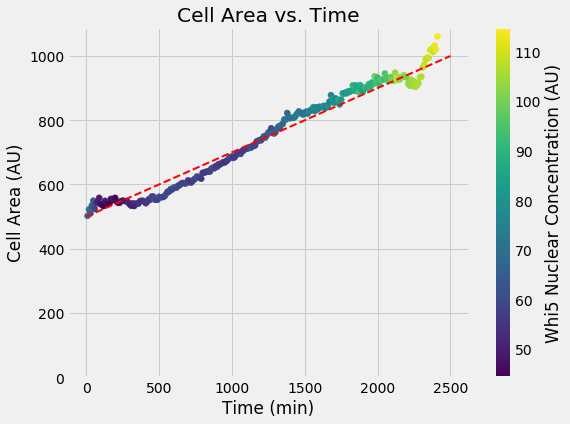

In [669]:
plt.figure(figsize=(8, 6))
plt.scatter(data.groupby(['min']).mean().index, data.groupby(['min']).mean()['area'], c=data.groupby(['min']).mean()['signal'])
plt.plot([0, 2500], [500, 1000], c='r', linestyle='--', linewidth=2)
plt.title('Cell Area vs. Time')
plt.xlabel('Time (min)')
plt.ylabel('Cell Area (AU)')
plt.ylim(ymin=0)

cbar = plt.colorbar()
cbar.set_label('Whi5 Nuclear Concentration (AU)')

# Linear Regression Stats

In [433]:
before_last_gen =  data.groupby(by=['pos', 'label']).apply(lambda x: x[x['thresh_count'] < x['thresh_count'].max()])
before_last_gen.drop(['pos', 'label'], axis=1, inplace=True)

after_last_gen = data.groupby(by=['pos', 'label']).apply(lambda x: x[x['thresh_count'] >= x['thresh_count'].max()])
mean_after_size = int(after_last_gen.groupby(by=['pos', 'label']).size().mean())
after_last_gen = after_last_gen.groupby(by=['pos', 'label']).filter(lambda x: len(x) >= 8)
after_last_gen.drop(['pos', 'label'], axis=1, inplace=True)

blg_lin = (before_last_gen.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'pre-slope',
                        1: 'pre-intercept',
                        2: 'pre-rvalue',
                        3: 'pre-pvalue',
                        4: 'pre-stderr'
                      })
       )

alg_lin = (after_last_gen.groupby(by=['pos', 'label']).apply(lambda x: pd.Series(linregress(x['min'], x['area'])))
               .rename(columns={
                        0: 'post-slope',
                        1: 'post-intercept',
                        2: 'post-rvalue',
                        3: 'post-pvalue',
                        4: 'post-stderr'
                      })
       )

lin_data = pd.merge(blg_lin, alg_lin, on=['pos', 'label'], how='outer')
lin_data = lin_data.dropna(axis=0)

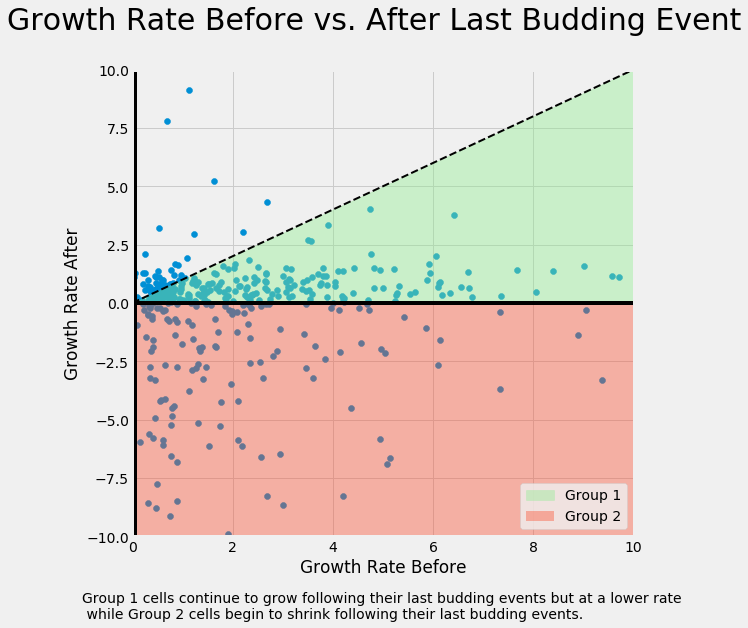

In [434]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(lin_data['pre-slope'], lin_data['post-slope'], label = '_nolegend_')
plt.xlabel('Growth Rate Before')
plt.ylabel('Growth Rate After')
plt.figtext(.5, .95, 'Growth Rate Before vs. After Last Budding Event', fontsize=30, ha='center')

plt.xlim(xmin=0, xmax=10)
plt.ylim(ymin=-10, ymax=10)

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k', linewidth = 10)

ax.plot([0, 10], [0, 10], color='k', linestyle='--', linewidth = 2)

plt.fill_between([0, 10], [0, 10], alpha = .4, color = 'lightgreen', label = 'Group 1')
plt.fill_between([0, 10], [-10, -10], alpha = .4, label = 'Group 2')

plt.text(-1, -13.5, 'Group 1 cells continue to grow following their last budding events but at a lower rate \n while Group 2 cells begin to shrink following their last budding events.')

plt.legend()

# Testing for whi5 threshold (outdated)
The threshold for cell divison seems to be about 1.1 * median whi-5 nuclear concentration

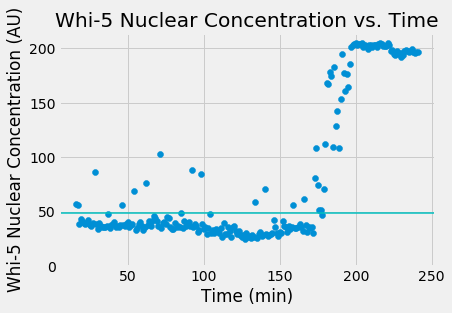

In [393]:
index = (data['pos']==1) & (data['label']==1)
plt.xlabel('Time (min)')
plt.ylabel('Whi-5 Nuclear Concentration (AU)')
plt.title('Whi-5 Nuclear Concentration vs. Time')
plt.scatter(data[index]['time'], data[index]['signal'])
plt.ylim(ymin=0)

threshold = data[index]['signal'].median() * 1.25

plt.axhline(threshold, c='c', linewidth = 1.5)
threshold_values = data[index & (data['signal'] >= threshold)]['time']
#for x in threshold_values:
    #plt.axvline(x, c='r', linewidth = 1.5)


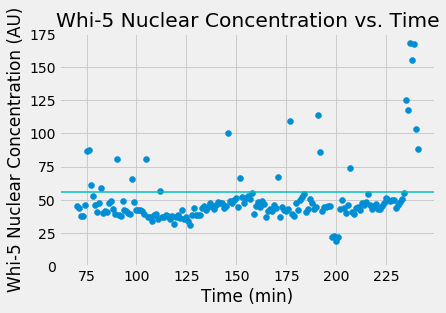

In [394]:
index = (data['pos']==1) & (data['label']==2)
plt.xlabel('Time (min)')
plt.ylabel('Whi-5 Nuclear Concentration (AU)')
plt.title('Whi-5 Nuclear Concentration vs. Time')
plt.scatter(data[index]['time'], data[index]['signal'])
plt.ylim(ymin=0)

threshold = data[index]['signal'].median() * 1.25

plt.axhline(threshold, c='c', linewidth = 1.5)
threshold_values = data[index & (data['signal'] >= threshold)]['time']
#for x in threshold_values:
    #plt.axvline(x, c='r', linewidth = 1.5)


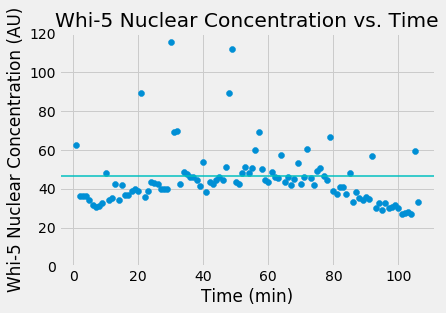

In [447]:
index = (data['pos']==1) & (data['label']==8)
plt.xlabel('Time (min)')
plt.ylabel('Whi-5 Nuclear Concentration (AU)')
plt.title('Whi-5 Nuclear Concentration vs. Time')
plt.scatter(data[index]['time'], data[index]['signal'])
plt.ylim(ymin=0)

threshold = data[index]['signal'].median() * 1.1

plt.axhline(threshold, c='c', linewidth = 1.5)
threshold_values = data[index & (data['signal'] >= threshold)]['signal']
#for x in threshold_values:
    #plt.axvline(x, c='r', linewidth = 1.5)

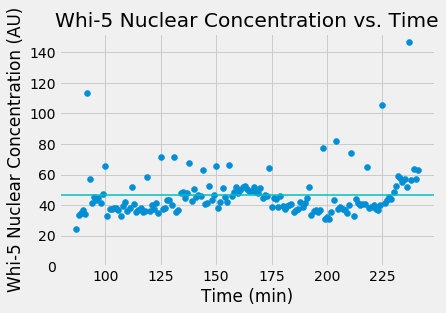

In [449]:
index = (data['pos']==1) & (data['label']==4)
plt.xlabel('Time (min)')
plt.ylabel('Whi-5 Nuclear Concentration (AU)')
plt.title('Whi-5 Nuclear Concentration vs. Time')
plt.scatter(data[index]['time'], data[index]['signal'])
plt.ylim(ymin=0)

threshold = data[index]['signal'].median() * 1.1

plt.axhline(threshold, c='c', linewidth = 1.5)
threshold_values = data[index & (data['signal'] >= threshold)]['time']
#for x in threshold_values:
    #plt.axvline(x, c='r', linewidth = 1.5)


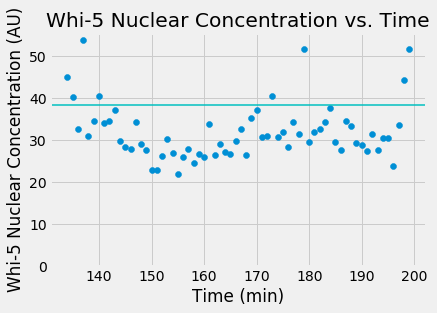

In [453]:
index = (data['pos']==1) & (data['label']==15)
plt.xlabel('Time (min)')
plt.ylabel('Whi-5 Nuclear Concentration (AU)')
plt.title('Whi-5 Nuclear Concentration vs. Time')
plt.scatter(data[index]['time'], data[index]['signal'])
plt.ylim(ymin=0)

threshold = data[index]['signal'].median() * 1.25

plt.axhline(threshold, c='c', linewidth = 1.5)
threshold_values = data[index & (data['signal'] >= threshold)]['time']
#for x in threshold_values:
    #plt.axvline(x, c='r', linewidth = 1.5)


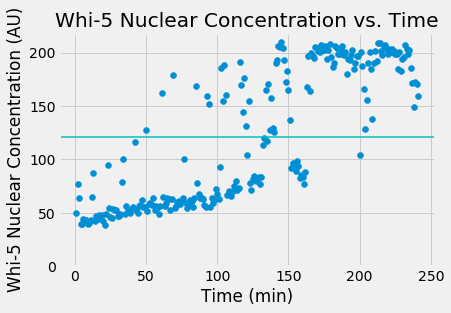

In [455]:
index = (data['pos']==32) & (data['label']==1)
plt.xlabel('Time (min)')
plt.ylabel('Whi-5 Nuclear Concentration (AU)')
plt.title('Whi-5 Nuclear Concentration vs. Time')
plt.scatter(data[index]['time'], data[index]['signal'])
plt.ylim(ymin=0)

threshold = data[index]['signal'].median() * 1.25

plt.axhline(threshold, c='c', linewidth = 1.5)
threshold_values = data[index & (data['signal'] >= threshold)]['time']
#for x in threshold_values:
    #plt.axvline(x, c='r', linewidth = 1.5)
